# Multi-Task Learning on Cifar10 Dataset: A Vision Transformer Approach
- **Name**: Minh T. Nguyen & Peter Chen.
- **ECE 6524** - Final Project.
- **Date**: 4/18/2023.
- **Objective**: Build a Multi-Task model for image classification on Cifar10.

### References:
- Paper: ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929).
- [Author's Github Repository](https://github.com/google-research/vision_transformer).
- [Keras' Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

### Vision Transformers Architecture Explanation
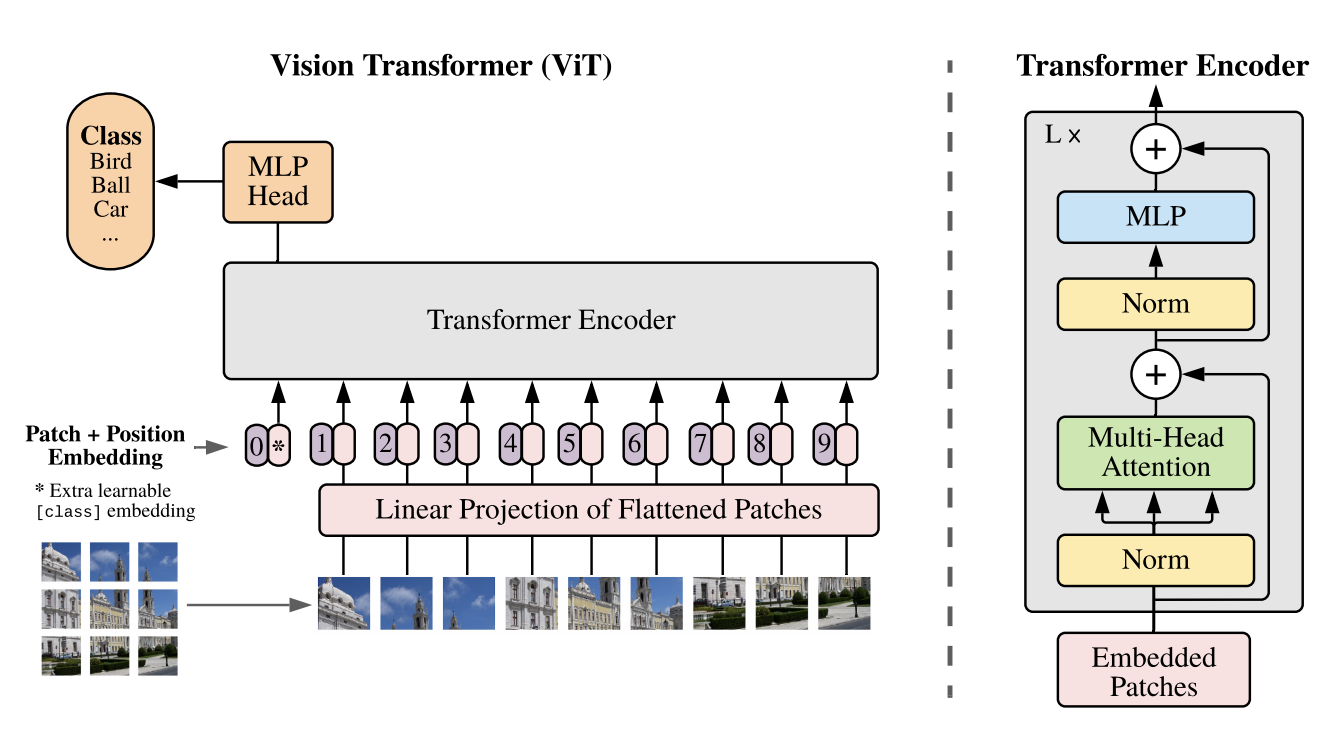

- **About**: Visions tasks were dominated by CNN-based architecture. However, Vision Transformers (ViT) has showed to be a high-capacity network architecture and can outperform CNN-based network on vision Tasks.
- **ViT Architecture**:
    - **Pipeline**: ViT computes the attentions between patches instead of image pixels due to limitation in computational power. **Input > Linear Projection > Stacked Encoder > MLP > Output Labels**
    - **Input Processing**: 
        - Convert Image to Patches.
        - Linear Projection: Each patch is reshaped to 1D vector, then we multiple with a learnable matrix to create a vector (patch linear projection). By doing for all patches, we will get an image linear projection.
        - Position Embedding: ViT is invariant to position on patches. For CNN, convolution is translation and scale equivariant (important for object detection) while pooling is translation and scale invariant (important for image recognition). By combining convolution and pooling, CNN can deal with recognition, object detection, and segmentation. Position embedding allow ViT to behave like CNN. This is the only inductive bias in ViT.  
    - **Transformers Encoder - Self-attention + MLP**:
        - Why do we have Layer Normalization? To reduce training time and stabilizes training phases.
        - Why do we use Skip Connection? To improves the performance by as much as 4% on recognition by propagating representation across layers.
        - Why do we use Multi-Head Self-Attention? To learn different representation of self-attention matrix to boost performance.
    - **MLP + Output**: Prediction outputs.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras import layers
from keras.utils import np_utils, plot_model

# 1. Data Visualization & Preprocessing

In [2]:
num_classes = 10          # number of classes
num_super_classes = 2          # number of super-classes
input_shape = (32, 32, 3) # original input image size

In [3]:
# download data from Keras API
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


## 1.1. Data Visualization

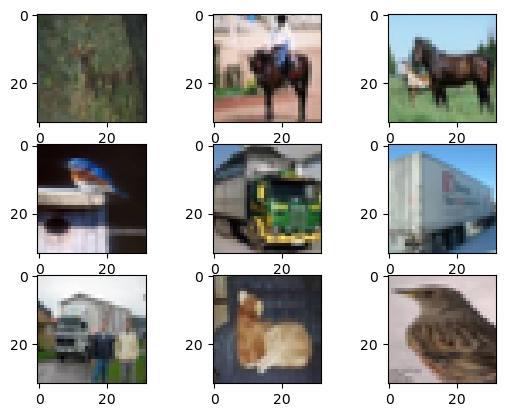

In [5]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Generate Superclasses
The super-classes are divided into animals and vehicles:
- Animals: Bird, Cat, Deer, Dog, Frog, Horse. (5000x6 training images, 1000x6 testing images).
- Vehicles: Airplane, Automotive, Ship, Truck. (5000x4 training images, 1000x4 testing images).

From Cifar 10 Dataset, we know that the labels have the corresponding label number:
- Airplane: 0.
- Automobile: 1.
- Bird: 2.
- Cat: 3.
- Deer: 4.
- Dog: 5.
- Frog: 6.
- Horse: 7.
- Ship: 8.
- Truck 9.

In [6]:
# define superclasses (0 = animal, 1 = vehicle)
animal_classes = [2, 3, 4, 5, 6, 7]
y_train_super = [0 if y in animal_classes else 1 for y in y_train] 
y_test_super = [0 if y in animal_classes else 1 for y in y_test]

In [7]:
# check dataset size
print(f"X={X_train.shape}, y={len(y_train_super)}")
print(f"X={X_test.shape}, y={len(y_test_super)}")

X=(50000, 32, 32, 3), y=50000
X=(10000, 32, 32, 3), y=10000


## 1.3. Data Processing

In [8]:
# convert class into one hot encoder
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print('\ny_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train_super)
y_test_super = np_utils.to_categorical(y_test_super)

print('\ny_train_super shape: ', y_train_super.shape)
print('y_test_super shape: ', y_test_super.shape)


y_train shape:  (50000, 10)
y_test shape:  (10000, 10)

y_train_super shape:  (50000, 2)
y_test_super shape:  (10000, 2)


## 1.2. Data Augmentation

In [9]:
# set images parameters
image_size = 72                                # resize image from 32x32x3 to 72x72x3
patch_size = 6                                 # each image will be divided into patch with each patches has size of 6x6
num_patches = (image_size // patch_size) ** 2  # total number of patches in an image

In [10]:
print(f"The total number of patches in an splitted image is {num_patches}.")

The total number of patches in an splitted image is 144.


In [11]:
# create a data augmentation layer
data_aug = keras.Sequential(
    [
        layers.Normalization(),                  # normalize image
        layers.Resizing(image_size, image_size), # resize image from 32x32x3 to 72x72x3
    ],
    name="data_augmentation",
)

# compute the mean and varaince of the training data for normalization
data_aug.layers[0].adapt(X_train)

## 1.3. Patch Transformation
**Note**: Convert an input image into a patch-dimension. The class Patch's job is to transform image to patch-dimension. For instance, with our input image as **(1, 72, 72, 3)** = (1 image, 72 width pixel, 72 height pixel, 3 color channel), the output will be **(1, 12, 12, 108)** = (1 image, 12 width patch, 12 height patch, 108 depth).

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        """Constructor"""
        super().__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        """Forward-pass function"""
        batch_size = tf.shape(images)[0]
        
        # pixel to patch conversion
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        
        # get depth
        patch_dims = patches.shape[-1]
        
        # resize
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

**Note**: Let's go through an example

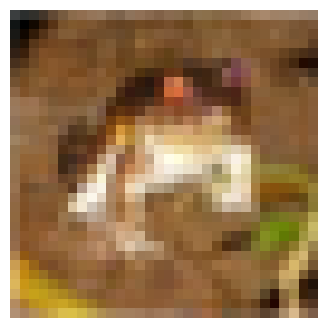

In [13]:
# plot original image
plt.figure(figsize=(4,4))
image = X_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.show()

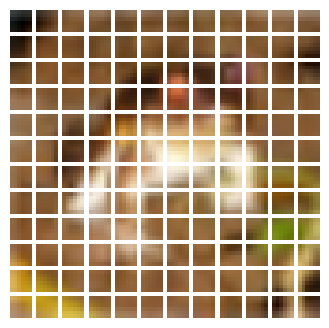

In [14]:
# resize and patch the image
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)

# get number of patch width (or height)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

# patch the image and visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Note**: Let's get some calculated patches results after the transformation

In [15]:
print(f"Original image size: {image_size} x {image_size}.")
print(f"Calculated patch size: {patch_size} x {patch_size}.")
print(f"Number of patches per image: {patches.shape[1]}.")
print(f"Depth size of each patch: {patches.shape[-1]}.")

Original image size: 72 x 72.
Calculated patch size: 6 x 6.
Number of patches per image: 144.
Depth size of each patch: 108.


# 2. Modeling
**Note**: Build a Patch Encoding Layer and Build a Vision Transformers architecture.

In [16]:
# the size of the project dimension is just how depth the PatchEncoder layer prior to fetch to the Transformers
projection_dim = 64 

## 2.1. Patch Encoding Layer
**Note**: We will fetch each patch through a "Linear Projection of Flatten Patches" (aka, transform dimension via Dense layer) and attached the learnable Positional Embedding layer.

**Note**: Let's first visualize the positional embedding matrix. Each number is the position of each patch.

In [17]:
print(tf.range(start=0, limit=144, delta=1))

tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143], shape=(144,), dtype=int32)


In [18]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        """Constructor"""
        super().__init__()
        self.num_patches = num_patches                       # (12 x 12) = 144 patches
        self.projection = layers.Dense(units=projection_dim) # Dense layer that map the patched input to the projection_dim
        self.position_embedding = layers.Embedding(          # learnable embedding layer for the position (above)
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        """Forward Pass"""
        # create a position matrix
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        
        # resize the input patch with Dense
        input_patch = self.projection(patch)
        
        # encode position array with learnable embedding layer
        pos_emb = self.position_embedding(positions)
        
        # patch + position embedding
        encoded_patch = input_patch + pos_emb
        
        return encoded_patch

## 2.2. Vision Transformers
**Note**: Input > Linear Projection > Stacked Encoder > MLP > Output Labels

In [19]:
# training settings
batch_size = 256          # number of images per batch
num_heads = 4             # nummber of attention heads in the multi-attention layer
num_epochs = 20           # number of training epochs
transformer_dropout = 0.2 # dropout rate of mlp inner of transformers
mlp_dropout = 0.2         # dropout rate of mlp outside of transformers

# transformers settings
transformer_layers = 8    # number of stacked encoder layers

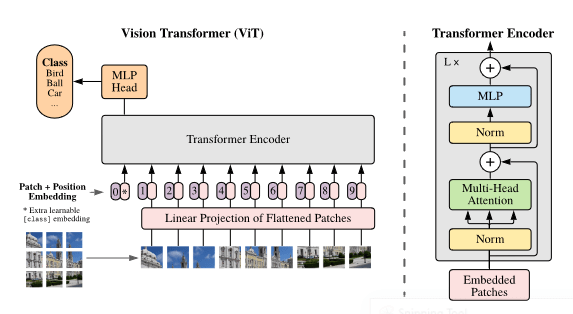

In [20]:
def create_model(mlp_dropout):
    # set input layer
    inputs = layers.Input(shape=input_shape, name="input")

    # normalize and resize image
    augmented = data_aug(inputs)

    # convert image's pixels into patches
    patches = Patches(patch_size)(augmented)

    # encode patch by linearly transform patch with dense and add the learnable position encoder
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # create stacked encoder
    for _ in range(transformer_layers):
        # layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # multi-head attention
        mtha = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # skip connection 1 = add input with mtha
        x2 = layers.Add()([mtha, encoded_patches])

        # layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x4 = layers.Dense(projection_dim * 2, activation=tf.nn.gelu)(x3)
        x4 = layers.Dropout(transformer_dropout)(x4)
        x4 = layers.Dense(projection_dim, activation=tf.nn.gelu)(x4)
        x4 = layers.Dropout(transformer_dropout)(x4)

        # skip connection 2
        encoded_patches = layers.Add()([x4, x2])

    # flatten transformers
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(mlp_dropout)(representation)
    features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
    features = layers.Dropout(mlp_dropout)(features)
    
    # task 1 branch - fully connected for coarse-class classification
    task_1_branch = layers.Dense(1024, activation=tf.nn.gelu)(features)
    task_1_branch = layers.Dropout(mlp_dropout)(task_1_branch)
    task_1_branch = layers.Dense(512, activation=tf.nn.gelu)(task_1_branch)
    task_1_branch = layers.Dropout(mlp_dropout)(task_1_branch)
    task_1_branch = layers.Dense(256, activation=tf.nn.gelu)(task_1_branch)
    task_1_branch = layers.Dropout(mlp_dropout)(task_1_branch)
    task_1_branch = layers.Dense(128, activation=tf.nn.gelu)(task_1_branch)
    task_1_branch = layers.Dropout(mlp_dropout)(task_1_branch)
    task_1_branch = layers.Dense(num_classes, activation="softmax", name="task_1_output")(task_1_branch)
    
    # task 2 branch - fully connected for fine-class classification
    task_2_branch = layers.Dense(512, activation=tf.nn.gelu)(features)
    task_2_branch = layers.Dropout(mlp_dropout)(task_2_branch)
    task_2_branch = layers.Dense(256, activation=tf.nn.gelu)(task_2_branch)
    task_2_branch = layers.Dropout(mlp_dropout)(task_2_branch)
    task_2_branch = layers.Dense(128, activation=tf.nn.gelu)(task_2_branch)
    task_2_branch = layers.Dropout(mlp_dropout)(task_2_branch)
    task_2_branch = layers.Dense(num_super_classes, activation="softmax", name="task_2_output")(task_2_branch)
        
    # create model
    model = keras.Model(inputs=inputs, outputs=[task_1_branch, task_2_branch])
    
    return model

In [21]:
# create a model
model = create_model(mlp_dropout=mlp_dropout)

In [22]:
# print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input[0][0]']                  
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

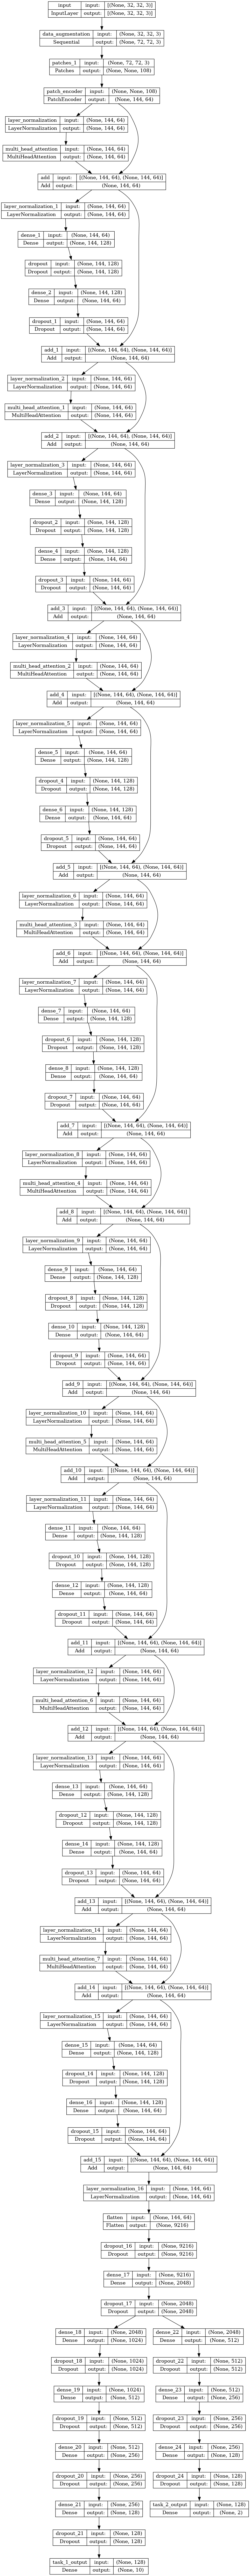

In [23]:
# plot architectures
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 2.3. Compile Model

In [24]:
# set gamma
gamma = 0.5

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

## 2.4. Train & Validate Model

In [25]:
# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

In [26]:
# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20
167/167 [==============================] - 98s 373ms/step - loss: 1.0295 - task_1_output_loss: 1.7217 - task_2_output_loss: 0.3373 - task_1_output_accuracy: 0.3746 - task_2_output_accuracy: 0.8608 - val_loss: 0.9886 - val_task_1_output_loss: 1.5763 - val_task_2_output_loss: 0.4009 - val_task_1_output_accuracy: 0.4653 - val_task_2_output_accuracy: 0.8499
Epoch 2/20
167/167 [==============================] - 61s 364ms/step - loss: 0.7822 - task_1_output_loss: 1.3415 - task_2_output_loss: 0.2229 - task_1_output_accuracy: 0.5261 - task_2_output_accuracy: 0.9130 - val_loss: 0.7038 - val_task_1_output_loss: 1.2114 - val_task_2_output_loss: 0.1962 - val_task_1_output_accuracy: 0.5719 - val_task_2_output_accuracy: 0.9223
Epoch 3/20
167/167 [==============================] - 62s 372ms/step - loss: 0.6502 - task_1_output_loss: 1.1291 - task_2_output_loss: 0.1713 - task_1_output_accuracy: 0.6049 - task_2_output_accuracy: 0.9337 - val_loss: 0.8517 - val_task_1_output_loss: 1.4533 - val_

In [27]:
# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

Train loss: 0.050834983587265015
Train task 1 loss: 0.09138604998588562
Train task 2 loss: 0.01028386875987053
Train task 1 acc: 0.9719294309616089
Train task 2 acc: 0.9966117739677429


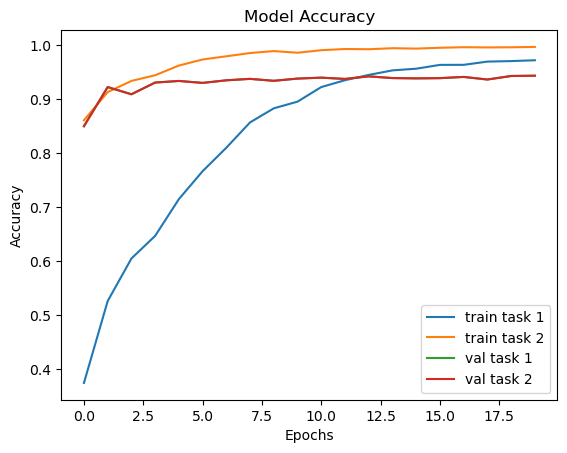

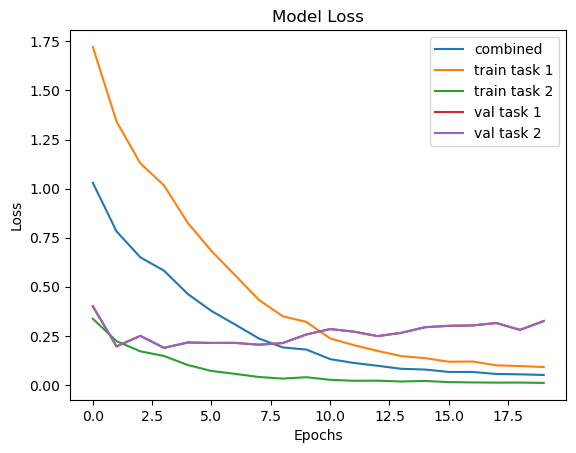

In [28]:
# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

## 2.5. Test Trained Model

In [29]:
# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 1.0968410968780518
Test task 1 loss: 1.859824776649475
Test task 2 loss: 0.33385732769966125
Test task 1 acc: 0.6718000173568726
Test task 2 acc: 0.9401999711990356


# 3. Optimize ViT with Different Parameters

## 3.1. Case 1  - Batch Size = 256, Dropout-MLP=0, Adam Optimizer (Trained Aboved)

In [30]:
# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

Train loss: 0.050834983587265015
Train task 1 loss: 0.09138604998588562
Train task 2 loss: 0.01028386875987053
Train task 1 acc: 0.9719294309616089
Train task 2 acc: 0.9966117739677429


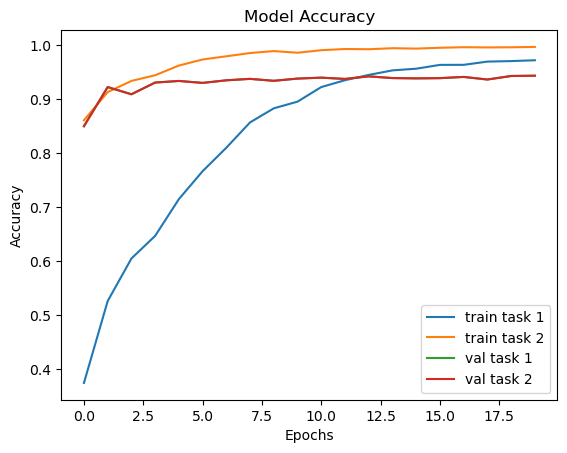

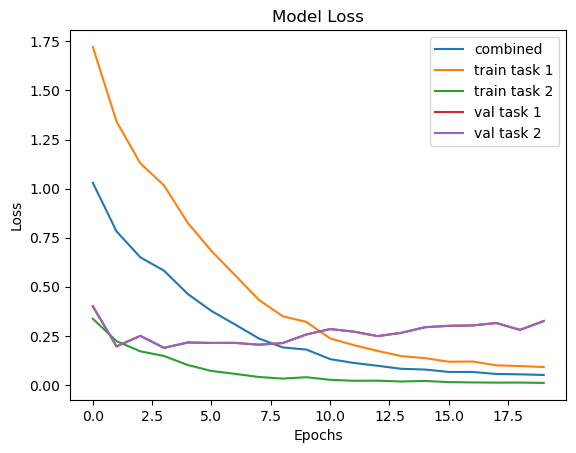

In [31]:
# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

In [32]:
# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

Test loss: 1.0968410968780518
Test task 1 loss: 1.859824776649475
Test task 2 loss: 0.33385732769966125
Test task 1 acc: 0.6718000173568726
Test task 2 acc: 0.9401999711990356


## 3.2. Case 2  - Batch Size = 256, Gamma=0.4, Adam Optimizer

Epoch 1/20
167/167 [==============================] - 92s 378ms/step - loss: 0.8937 - task_1_output_loss: 1.7306 - task_2_output_loss: 0.3358 - task_1_output_accuracy: 0.3716 - task_2_output_accuracy: 0.8618 - val_loss: 0.7102 - val_task_1_output_loss: 1.4122 - val_task_2_output_loss: 0.2422 - val_task_1_output_accuracy: 0.4935 - val_task_2_output_accuracy: 0.9025
Epoch 2/20
167/167 [==============================] - 61s 368ms/step - loss: 0.6872 - task_1_output_loss: 1.3811 - task_2_output_loss: 0.2246 - task_1_output_accuracy: 0.5096 - task_2_output_accuracy: 0.9128 - val_loss: 0.6249 - val_task_1_output_loss: 1.2353 - val_task_2_output_loss: 0.2181 - val_task_1_output_accuracy: 0.5601 - val_task_2_output_accuracy: 0.9133
Epoch 3/20
167/167 [==============================] - 63s 378ms/step - loss: 0.5620 - task_1_output_loss: 1.1516 - task_2_output_loss: 0.1689 - task_1_output_accuracy: 0.5947 - task_2_output_accuracy: 0.9355 - val_loss: 0.5729 - val_task_1_output_loss: 1.1735 - val_

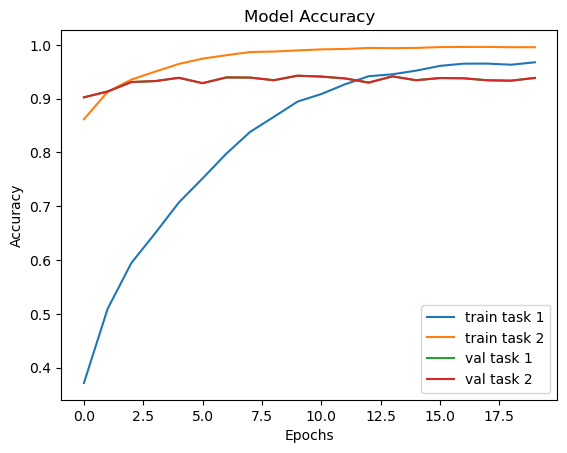

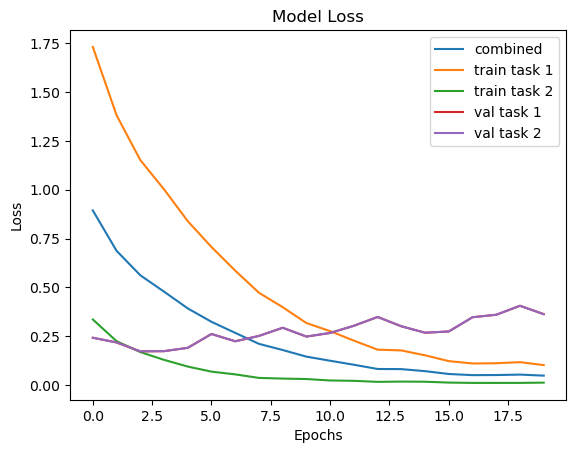

Test loss: 0.8686716556549072
Test task 1 loss: 1.682499647140503
Test task 2 loss: 0.3261198103427887
Test task 1 acc: 0.6697999835014343
Test task 2 acc: 0.9434999823570251


In [33]:
# training settings
batch_size = 256          # number of images per batch

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# set gamma
gamma = 0.4

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

## 3.3. Case 3  - Batch Size = 256, Gamma=0.6, Adam Optimizer

Epoch 1/20
167/167 [==============================] - 93s 378ms/step - loss: 1.1704 - task_1_output_loss: 1.7240 - task_2_output_loss: 0.3398 - task_1_output_accuracy: 0.3750 - task_2_output_accuracy: 0.8580 - val_loss: 0.9682 - val_task_1_output_loss: 1.4363 - val_task_2_output_loss: 0.2661 - val_task_1_output_accuracy: 0.4873 - val_task_2_output_accuracy: 0.8900
Epoch 2/20
167/167 [==============================] - 61s 368ms/step - loss: 0.8843 - task_1_output_loss: 1.3282 - task_2_output_loss: 0.2184 - task_1_output_accuracy: 0.5316 - task_2_output_accuracy: 0.9121 - val_loss: 0.8647 - val_task_1_output_loss: 1.2998 - val_task_2_output_loss: 0.2120 - val_task_1_output_accuracy: 0.5488 - val_task_2_output_accuracy: 0.9157
Epoch 3/20
167/167 [==============================] - 63s 379ms/step - loss: 0.7479 - task_1_output_loss: 1.1309 - task_2_output_loss: 0.1733 - task_1_output_accuracy: 0.6065 - task_2_output_accuracy: 0.9336 - val_loss: 0.8578 - val_task_1_output_loss: 1.2642 - val_

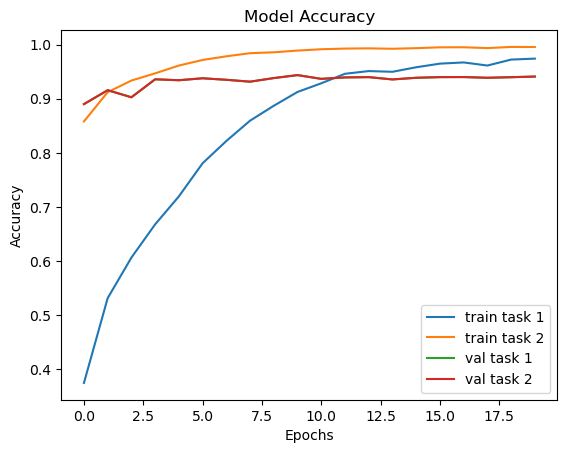

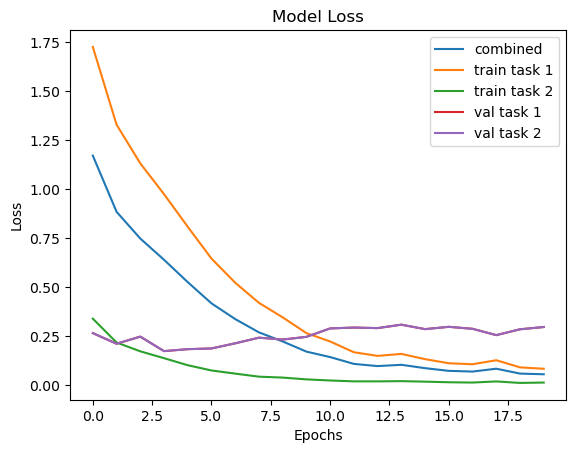

Test loss: 1.1399550437927246
Test task 1 loss: 1.69630765914917
Test task 2 loss: 0.3054260313510895
Test task 1 acc: 0.6669999957084656
Test task 2 acc: 0.9387999773025513


In [34]:
# training settings
batch_size = 256          # number of images per batch

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# set gamma
gamma = 0.6

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

## 3.4. Case 4  - Batch Size = 128, Gamma=0.5, Adam Optimizer

Epoch 1/20
333/333 [==============================] - 95s 202ms/step - loss: 1.0271 - task_1_output_loss: 1.7220 - task_2_output_loss: 0.3322 - task_1_output_accuracy: 0.3783 - task_2_output_accuracy: 0.8655 - val_loss: 0.7976 - val_task_1_output_loss: 1.3753 - val_task_2_output_loss: 0.2199 - val_task_1_output_accuracy: 0.5049 - val_task_2_output_accuracy: 0.9137
Epoch 2/20
333/333 [==============================] - 67s 202ms/step - loss: 0.7694 - task_1_output_loss: 1.3303 - task_2_output_loss: 0.2084 - task_1_output_accuracy: 0.5288 - task_2_output_accuracy: 0.9186 - val_loss: 0.7219 - val_task_1_output_loss: 1.2219 - val_task_2_output_loss: 0.2219 - val_task_1_output_accuracy: 0.5589 - val_task_2_output_accuracy: 0.9112
Epoch 3/20
333/333 [==============================] - 67s 202ms/step - loss: 0.6525 - task_1_output_loss: 1.1382 - task_2_output_loss: 0.1668 - task_1_output_accuracy: 0.6057 - task_2_output_accuracy: 0.9363 - val_loss: 0.6633 - val_task_1_output_loss: 1.1425 - val_

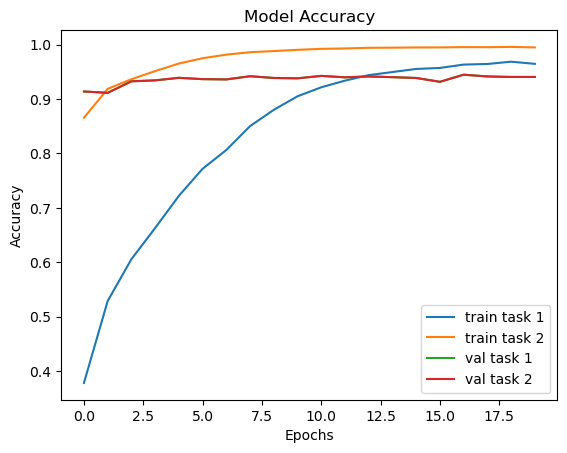

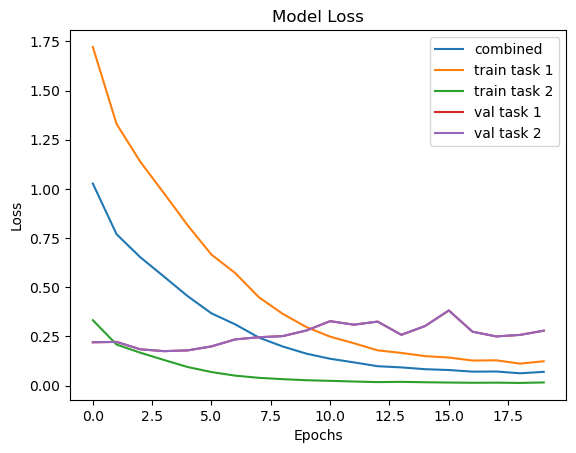

Test loss: 0.9469379186630249
Test task 1 loss: 1.6100170612335205
Test task 2 loss: 0.28385838866233826
Test task 1 acc: 0.6747000217437744
Test task 2 acc: 0.9373999834060669


In [35]:
# training settings
batch_size = 128          # number of images per batch

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# set gamma
gamma = 0.5

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])

## 3.5. Case 5  - Batch Size = 128, Gamma=0.5, SGD Optimizer

Epoch 1/20
333/333 [==============================] - 85s 204ms/step - loss: 1.3370 - task_1_output_loss: 2.1596 - task_2_output_loss: 0.5144 - task_1_output_accuracy: 0.1983 - task_2_output_accuracy: 0.7624 - val_loss: 1.1710 - val_task_1_output_loss: 1.9097 - val_task_2_output_loss: 0.4324 - val_task_1_output_accuracy: 0.3144 - val_task_2_output_accuracy: 0.8096
Epoch 2/20
333/333 [==============================] - 65s 195ms/step - loss: 1.1872 - task_1_output_loss: 1.9451 - task_2_output_loss: 0.4293 - task_1_output_accuracy: 0.2837 - task_2_output_accuracy: 0.8132 - val_loss: 1.1091 - val_task_1_output_loss: 1.8011 - val_task_2_output_loss: 0.4170 - val_task_1_output_accuracy: 0.3408 - val_task_2_output_accuracy: 0.8249
Epoch 3/20
333/333 [==============================] - 66s 199ms/step - loss: 1.1174 - task_1_output_loss: 1.8394 - task_2_output_loss: 0.3953 - task_1_output_accuracy: 0.3301 - task_2_output_accuracy: 0.8326 - val_loss: 1.0567 - val_task_1_output_loss: 1.7373 - val_

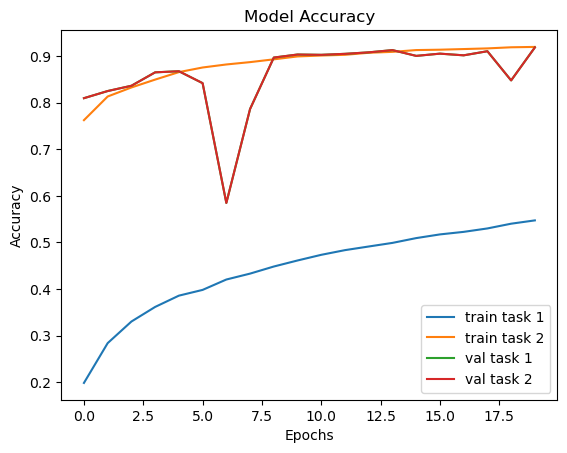

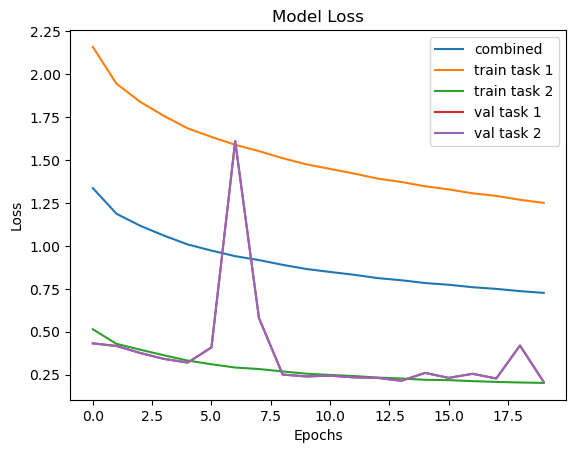

Test loss: 0.7279106974601746
Test task 1 loss: 1.2513192892074585
Test task 2 loss: 0.2045019119977951
Test task 1 acc: 0.5525000095367432
Test task 2 acc: 0.9207000136375427


In [36]:
# training settings
batch_size = 128          # number of images per batch

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# set gamma
gamma = 0.5

# compile model
model.compile(loss={'task_1_output': 'categorical_crossentropy',
                    'task_2_output': 'binary_crossentropy'},
              loss_weights={'task_1_output': gamma,
                            'task_2_output': 1-gamma},
              optimizer='sgd',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    {'input': X_train},
    {'task_1_output': y_train, 'task_2_output': y_train_super},
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train task 1 loss:', history.history['task_1_output_loss'][-1])
print('Train task 2 loss:', history.history['task_2_output_loss'][-1])
print('Train task 1 acc:', history.history['task_1_output_accuracy'][-1])
print('Train task 2 acc:', history.history['task_2_output_accuracy'][-1])

# accuracy plot
plt.plot(history.history['task_1_output_accuracy'])
plt.plot(history.history['task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.plot(history.history['val_task_2_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['task_1_output_loss'])
plt.plot(history.history['task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.plot(history.history['val_task_2_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['combined' ,'train task 1', 'train task 2', 'val task 1', 'val task 2'])
plt.show()

# test model results
evaluation_results  = model.evaluate(X_test, 
                        [y_test, y_test_super],
                       batch_size=batch_size,
                       verbose=0)

# train model results
print('Test loss:', evaluation_results[0])
print('Test task 1 loss:', evaluation_results[1])
print('Test task 2 loss:', evaluation_results[2])
print('Test task 1 acc:', evaluation_results[3])
print('Test task 2 acc:', evaluation_results[4])